In [1]:
#%pip install numpy matplotlib zarr xarray ipykernel gcsfs fsspec dask cartopy ocf-blosc2 torchinfo
#%pip install -U doxa-cli

Note: you may need to restart the kernel to use updated packages.


  Using cached requests-2.26.0-py2.py3-none-any.whl (62 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: doxa-cli
    Found existing installation: doxa-cli 0.1.5
    Uninstalling doxa-cli-0.1.5:
      Successfully uninstalled doxa-cli-0.1.5
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.11.1 requires ruamel-yaml, which is not installed.
translate-json 0.0.2 requires certifi==2021.5.30, but you have certifi 2023.5.7 which is incompatible.
translate-json 0.0.2 requires idna==3.2; python_version >= "3", but you have idna 2.10 which is incompatible.
osmnx 1.9.1 requires requests>=2.27, but you have requests 2.26.0 which is incompatible.
conda-repo-cli 1.0.20 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.20 requires nbformat==5.4.0, but you have nbformat 5.5.0 which is incompatible.
conda-repo-cli 1.0.20 requires requests==2.28.1, but you have requests 2.26.0 which is incompatible.


## Importing packages

Here, we import a number of packages we will need to train our first model.

In [1]:
!pip install pvlib

In [2]:
import os
from datetime import datetime, time, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
from ocf_blosc2 import Blosc2
from torch.utils.data import DataLoader, IterableDataset
from torchinfo import summary
import json
import geopandas as gpd
import seaborn as sns
from scipy.ndimage import zoom
import numpy as np
import h5py
import pvlib 
import math
import torch.nn.functional as F

plt.rcParams["figure.figsize"] = (20, 12)

Run this block to install all data

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device
if not os.path.exists("submission"):
     os.makedirs("submission", exist_ok=True)
     #Installing locally means you do not need to rerun this each time you restart the notebook
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/competition.py --output submission/competition.py
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/doxa.yaml --output submission/doxa.yaml
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/model.py --output submission/model.py
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/run.py --output submission/run.py
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/indices.json --output indices.json
if not os.path.exists("data"):
    os.makedirs("data/pv/2020", exist_ok=True)
    os.makedirs("data/satellite-hrv/2020", exist_ok=True)

    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/metadata.csv --output data/pv/metadata.csv
    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/2020/7.parquet --output data/pv/2020/7.parquet
    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/satellite-hrv/2020/7.zarr.zip --output data/satellite-hrv/2020/7.zarr.zip
pv = pd.read_parquet("data/pv/2020/7.parquet").drop("generation_wh", axis=1)
pv.index = pv.index.set_levels([pv.index.levels[0].tz_localize(None), pv.index.levels[1]])

#The parquet data here is similar to a dataframe. The "power" is the column with the other data types being indexes. The data is shaped with each timestamp being its own sub frame with the sites having their corresponding power (I think this is the % of their total possible yield).  
hrv = xr.open_dataset(
    "data/satellite-hrv/2020/7.zarr.zip", engine="zarr", chunks="auto"
)
#The way that this works is that it stores the image as a vector. The vectors are stored as an array of vectors. These then have a timestamp, as we only have one channel the array is a 1D set of vectors with the dimension being time. Read this to help you understand how this is being stored https://tutorial.xarray.dev/fundamentals/01_datastructures.html
# To access I have included some examples below
#The float value (float16-float64) shows the precision with which data is stored. Later on it is important to make sure that when you are feeding in data into the model that the float type matches between data types, this currently is not a problem when only using the HRV data. I am not yet sure if this will be a problem when using the NWP data.
with open("indices.json") as f:
    site_locations = {
        data_source: {
            int(site): (int(location[0]), int(location[1]))
            for site, location in locations.items()
        }
        for data_source, locations in json.load(f).items()
    }
if not os.path.exists("data"):
    os.makedirs("data/pv/2020", exist_ok=True)
    os.makedirs("data/satellite-hrv/2020", exist_ok=True)

    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/metadata.csv --output data/pv/metadata.csv
    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/2020/7.parquet --output data/pv/2020/7.parquet
    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/satellite-hrv/2020/7.zarr.zip --output data/satellite-hrv/2020/7.zarr.zip 

## For finding the average distance between a site and its nearest neighbour

In [4]:
#Note that not all the sites in the PV sets line up with the sites in the indices set later on so not all of them can be plotted using a CRS system as the pv object has the CRS coordinates for some and not all of the sites. This is not an issue for the model but is for plotting all the sites on a mao should we want to include this.
####################This block is used for plotting, you do not need to run this block to run the models############################
#here I am getting the long and lat for all of our sites in the data set so that they can be plotted
pv_kwh = pd.read_parquet("data/pv/2020/7.parquet")#used for generating charts
pv_kwh
pv_ss_id = pv.index.get_level_values("ss_id").unique()
pv_ss_time = pv.index.get_level_values("timestamp")
pv_meta = pd.read_csv("data/pv/metadata.csv")
pv_meta_ssid = pv_meta.ss_id
shared_id = [x for x in pv_ss_id if x in pv_meta_ssid]
pv_shared = pv_meta[pv_meta["ss_id"].isin(shared_id)] #shared location data, only 698 of 908 sites in the pv file have long and lat for plotting


# Getting the average daily power yield for each site 
pv_kwh_y = pv_kwh.reset_index()
pv_kwh_y = pv_kwh_y.set_index('timestamp')

average_daily_kwh_yield = pv_kwh_y.groupby(['ss_id', pd.Grouper(freq='D')]).mean()

average_daily_kwh_yield = average_daily_kwh_yield.reset_index().drop(columns={"timestamp"}).rename(columns={"generation_wh":"generation_wh_avg"})

average_daily_kwh_yield = average_daily_kwh_yield.groupby("ss_id")["generation_wh_avg"].mean().reset_index()


# Getting the average daily kwh yield for each site 
pv_y = pv.reset_index()
pv_y = pv_y.set_index('timestamp')

average_daily_yield = pv_y.groupby(['ss_id', pd.Grouper(freq='D')]).mean()

average_daily_yield = average_daily_yield.reset_index().drop(columns={"timestamp"}).rename(columns={"power":"avg_power"})

average_daily_yield = average_daily_yield.groupby("ss_id")["avg_power"].mean().reset_index()

#merging dfs
pv_shared = pv_shared.merge(average_daily_yield, on="ss_id", how="left").dropna() #final output of the metadata file that contains the average daily yield for different sites
pv_shared = pv_shared.merge(average_daily_kwh_yield, on="ss_id", how="left").dropna() 

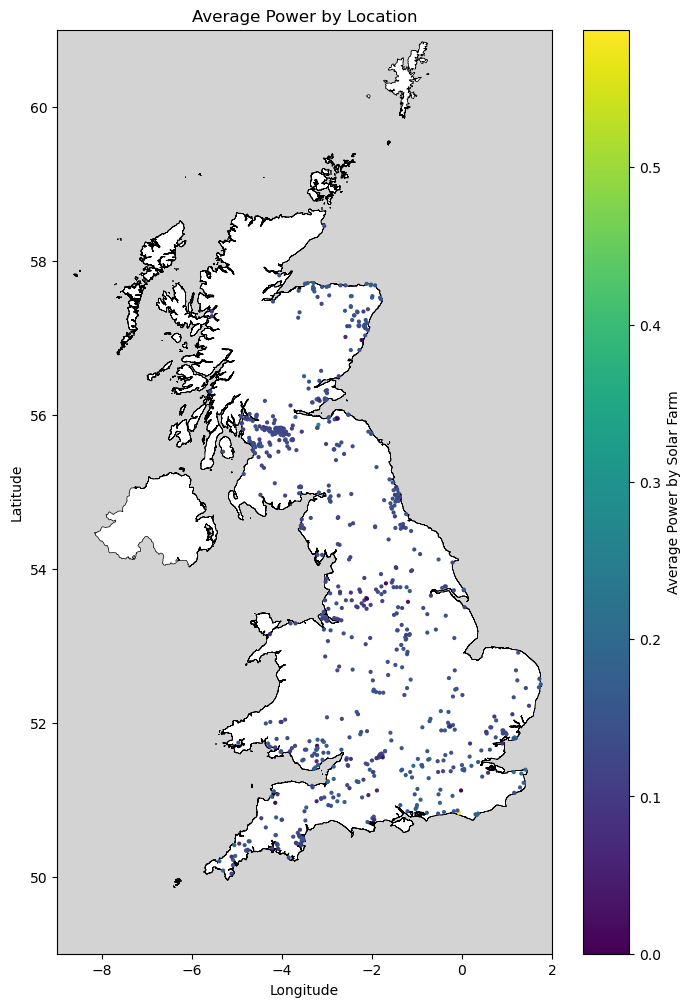

In [9]:
gdf = gpd.GeoDataFrame(
    pv_shared, geometry=gpd.points_from_xy(pv_shared.longitude_rounded, pv_shared.latitude_rounded)
)
gdf = gdf.set_crs("EPSG:4326")
uk_shp = r"/Users/Elzantohboonleong/Desktop/UCL/T2_Class/BENV0148 - Advance Machine Learning/GBR_adm0.shp"
uk = gpd.read_file(uk_shp)
uk = uk.to_crs(gdf.crs)

fig, ax = plt.subplots(1, 1, figsize=(8, 12))
ax.set_facecolor('lightgrey')

uk.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)

gdf.plot(ax=ax, column='avg_power', cmap='viridis', markersize=4, legend=True, legend_kwds={'label': 'Average Power by Solar Farm', 'orientation': "vertical"})

ax.set_xlim([-9, 2])
ax.set_ylim([49, 61])

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Average Power by Location')

plt.show()

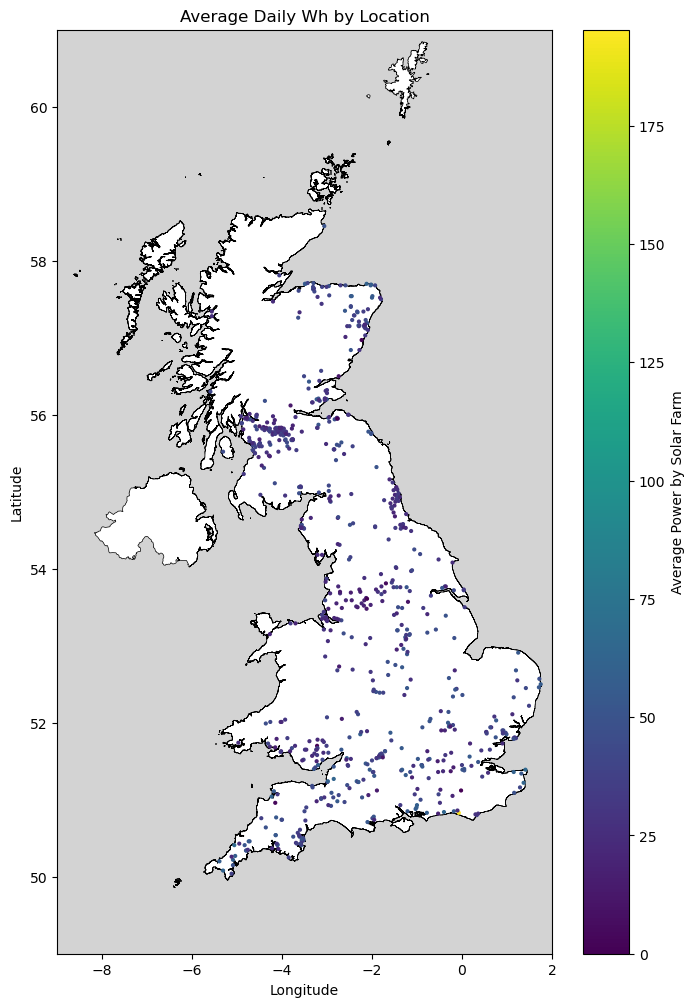

In [11]:
gdf = gpd.GeoDataFrame(
    pv_shared, geometry=gpd.points_from_xy(pv_shared.longitude_rounded, pv_shared.latitude_rounded)
)
gdf = gdf.set_crs("EPSG:4326")
uk_shp = r"/Users/Elzantohboonleong/Desktop/UCL/T2_Class/BENV0148 - Advance Machine Learning/GBR_adm0.shp"
uk = gpd.read_file(uk_shp)
uk = uk.to_crs(gdf.crs)

fig, ax = plt.subplots(1, 1, figsize=(8, 12))
ax.set_facecolor('lightgrey')

uk.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)

gdf.plot(ax=ax, column='generation_wh_avg', cmap='viridis', markersize=4, legend=True, legend_kwds={'label': 'Average Power by Solar Farm', 'orientation': "vertical"})

ax.set_xlim([-9, 2])
ax.set_ylim([49, 61])

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Average Daily Wh by Location')

plt.show()

In [12]:
!pip install geopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 1.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.1 MB/s eta 0:00:00


In [13]:
import geopandas as gpd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from geopy.distance import geodesic
from scipy import stats


In [14]:
def calculate_average_nearest_neighbor_distance(gdf):
    coords = np.array(list(zip(gdf.geometry.y, gdf.geometry.x)))
    
    nbrs = NearestNeighbors(n_neighbors=2, metric='haversine').fit(np.radians(coords))
    
    distances, indices = nbrs.kneighbors(np.radians(coords))
    
    distances_in_km = distances[:, 1] * 6371
    
    return np.mean(distances_in_km)

# Compute the average distance to the closest neighbor
average_distance = calculate_average_nearest_neighbor_distance(gdf)
print(f"Mean average distance to the solar farms closest neighbor: {average_distance:.2f} km")

Mean average distance to the solar farms closest neighbor: 6.01 km


## For generating the angle of solar incidence  

In [101]:
#this block finds the long and lat for the sites where it is available 
pv_ss_id = pv.index.get_level_values("ss_id").unique()
pv_ss_time = pv.index.get_level_values("timestamp")
pv_meta = pd.read_csv("data/pv/metadata.csv")
pv_meta_ssid = pv_meta.ss_id
shared_id = [x for x in pv_ss_id if x in pv_meta_ssid]
pv_shared = pv_meta[pv_meta["ss_id"].isin(shared_id)] #shared location data, only 698 of 908 sites in the pv file have long and lat for plotting


In [102]:
#Merges 
pv_shared_merge = pv_shared[["ss_id", "latitude_rounded", "longitude_rounded", "orientation", "tilt"]]
pv_reset = pv.reset_index()

pv_az = pd.merge(pv_reset, pv_shared_merge[['ss_id', 'latitude_rounded', 'longitude_rounded', "orientation", "tilt"]], on='ss_id', how='left').dropna().set_index(["timestamp", "ss_id"])
pv_az["altitude"] = 0
pv_az_pre = pv_az.reset_index()
print(pv_az_pre)

print(pv_az_pre.sample(10))

                  timestamp  ss_id  power  latitude_rounded  \
0       2020-07-01 00:00:00   2607    0.0             52.44   
1       2020-07-01 00:00:00   2626    0.0             54.99   
2       2020-07-01 00:00:00   2631    0.0             51.81   
3       2020-07-01 00:00:00   2657    0.0             51.49   
4       2020-07-01 00:00:00   2729    0.0             51.61   
...                     ...    ...    ...               ...   
6039341 2020-07-31 23:55:00  18873    0.0             53.59   
6039342 2020-07-31 23:55:00  18989    0.0             53.55   
6039343 2020-07-31 23:55:00  18990    0.0             53.76   
6039344 2020-07-31 23:55:00  22335    0.0             53.10   
6039345 2020-07-31 23:55:00  23083    0.0             53.06   

         longitude_rounded  orientation  tilt  altitude  
0                    -0.12        200.0  35.0         0  
1                    -3.18        270.0  22.0         0  
2                    -2.50        130.0  30.0         0  
3          

In [103]:
#Calculates the azimuth
#tz = 'Europe/London'
location_data = {
    'latitude': pv_az_pre['latitude_rounded'],  # Using mean latitude and longitude
    'longitude': pv_az_pre['longitude_rounded'],
    #'altitude': pv_az_pre['altitude'].mean()  # You may want to adjust how you handle altitude
}

# Convert timestamps from UTC to the UK timezone and sort
pv_az_pre['timestamp'] = pd.to_datetime(pv_az_pre['timestamp'], utc=True)#.dt.tz_convert(tz)
#retain the format of UTC to obtain the solar position. To minimise data handling errors
#pv_az_pre_times = pd.date_range('2020-07-01', '2020-07-31', freq='5min', tz='UTC')




In [104]:
#print(pv_az_pre)
location_data
#pv_az_pre_times

{'latitude': 0          52.44
 1          54.99
 2          51.81
 3          51.49
 4          51.61
            ...  
 6039341    53.59
 6039342    53.55
 6039343    53.76
 6039344    53.10
 6039345    53.06
 Name: latitude_rounded, Length: 6039346, dtype: float64,
 'longitude': 0         -0.12
 1         -3.18
 2         -2.50
 3          0.36
 4         -0.24
            ... 
 6039341   -3.04
 6039342   -2.23
 6039343   -1.52
 6039344   -2.04
 6039345   -2.98
 Name: longitude_rounded, Length: 6039346, dtype: float64}

In [105]:
# Create a single location object, 
#tz and Altitude are default as 0, hence we don't need to initialise them.
location = pvlib.location.Location(location_data['latitude'], location_data['longitude'])#, tz, location_data['altitude'])

# Calculate solar position for all times at once
solar_position = location.get_solarposition(pv_az_pre['timestamp'])


In [106]:
print(solar_position)

                           apparent_zenith      zenith  apparent_elevation  \
timestamp                                                                    
2020-07-01 00:00:00+00:00       104.469109  104.469109          -14.469109   
2020-07-01 00:00:00+00:00       101.844074  101.844074          -11.844074   
2020-07-01 00:00:00+00:00       105.043198  105.043198          -15.043198   
2020-07-01 00:00:00+00:00       105.423181  105.423181          -15.423181   
2020-07-01 00:00:00+00:00       105.297536  105.297536          -15.297536   
...                                    ...         ...                 ...   
2020-07-31 23:55:00+00:00       108.283641  108.283641          -18.283641   
2020-07-31 23:55:00+00:00       108.369427  108.369427          -18.369427   
2020-07-31 23:55:00+00:00       108.194781  108.194781          -18.194781   
2020-07-31 23:55:00+00:00       108.827588  108.827588          -18.827588   
2020-07-31 23:55:00+00:00       108.814521  108.814521          

In [107]:
# Assign the azimuth values directly
pv_az_pre['solar_azimuth'] = solar_position['azimuth'].values
pv_az_pre['solar_zenith'] = solar_position['zenith'].values

In [108]:
pv_az_pre

,timestamp,ss_id,power,latitude_rounded,longitude_rounded,orientation,tilt,altitude,solar_azimuth,solar_zenith
0,2020-07-01 00:00:00+00:00,2607,0.0,52.44,-0.12,200.0,35.0,0,358.963037,104.469109
1,2020-07-01 00:00:00+00:00,2626,0.0,54.99,-3.18,270.0,22.0,0,356.098345,101.844074
2,2020-07-01 00:00:00+00:00,2631,0.0,51.81,-2.50,130.0,30.0,0,356.693428,105.043198
3,2020-07-01 00:00:00+00:00,2657,0.0,51.49,0.36,185.0,47.0,0,359.416459,105.423181
4,2020-07-01 00:00:00+00:00,2729,0.0,51.61,-0.24,180.0,45.0,0,358.844604,105.297536
...,...,...,...,...,...,...,...,...,...,...
6039341,2020-07-31 23:55:00+00:00,18873,0.0,53.59,-3.04,290.0,35.0,0,354.111254,108.283641
6039342,2020-07-31 23:55:00+00:00,18989,0.0,53.55,-2.23,207.0,35.0,0,354.920280,108.369427
6039343,2020-07-31 23:55:00+00:00,18990,0.0,53.76,-1.52,180.0,34.0,0,355.636396,108.194781
6039344,2020-07-31 23:55:00+00:00,22335,0.0,53.10,-2.04,140.0,21.0,0,355.097534,108.827588


In [116]:
import numpy as np
#pv_az_pre['solar_azimuth_south'] = (pv_az_pre['solar_azimuth'] - 180) % 360#check to the see if this is generating the correct angle 
#pv_az_pre['solar_zenith'] = 90 - solar_position['elevation'].values#where does this come from?
pv_az_pre['solar_azimuth_radians'] = np.radians(pv_az_pre['solar_azimuth'])
#pv_az_pre['solar_azimuth_south_radians'] = np.radians(pv_az_pre['solar_azimuth_south'])

pv_az_pre['solar_zenith_radians'] = np.radians(pv_az_pre['solar_zenith'])
pv_az_pre["panel_tilt_radians"] = np.radians(pv_az_pre['tilt'])
#pv_az_pre["latitude_rounded_radians"] = np.radians(pv_az_pre['latitude_rounded'])
#pv_az_pre["longitude_rounded_radians"] = np.radians(pv_az_pre['longitude_rounded'])
pv_az_pre["panel_orientation_radians"] = np.radians(pv_az_pre['orientation'])

#pv_az_pre['timestamp'] = pv_az_pre['timestamp'].dt.tz_convert('UTC')

In [117]:

print(pv_az_pre)


                        timestamp  ss_id  power  latitude_rounded  \
0       2020-07-01 00:00:00+00:00   2607    0.0             52.44   
1       2020-07-01 00:00:00+00:00   2626    0.0             54.99   
2       2020-07-01 00:00:00+00:00   2631    0.0             51.81   
3       2020-07-01 00:00:00+00:00   2657    0.0             51.49   
4       2020-07-01 00:00:00+00:00   2729    0.0             51.61   
...                           ...    ...    ...               ...   
6039341 2020-07-31 23:55:00+00:00  18873    0.0             53.59   
6039342 2020-07-31 23:55:00+00:00  18989    0.0             53.55   
6039343 2020-07-31 23:55:00+00:00  18990    0.0             53.76   
6039344 2020-07-31 23:55:00+00:00  22335    0.0             53.10   
6039345 2020-07-31 23:55:00+00:00  23083    0.0             53.06   

         longitude_rounded  orientation  tilt  altitude  solar_azimuth  \
0                    -0.12        200.0  35.0         0     358.963037   
1                    -3

In [119]:
cos_theta_inc = (
    np.cos(pv_az_pre['solar_zenith_radians']) * np.cos(pv_az_pre['panel_tilt_radians']))+(np.sin(pv_az_pre['solar_zenith_radians']) * np.sin(pv_az_pre['panel_tilt_radians']) * np.cos((pv_az_pre['solar_azimuth_radians']-pv_az_pre["panel_orientation_radians"])))

print(cos_theta_inc)

0         -0.723039
1         -0.165356
2         -0.555973
3         -0.883046
4         -0.868472
             ...   
6039341   -0.019191
6039342   -0.719382
6039343   -0.788559
6039344   -0.578806
6039345   -0.561942
Length: 6039346, dtype: float64


In [122]:
#cos_theta_inc = np.clip(cos_theta_inc, -1.0, 1.0)

pv_az_pre['angle_of_incidence_radians'] = np.arccos(cos_theta_inc)
pv_az_pre['angle_of_incidence'] = np.degrees(pv_az_pre['angle_of_incidence_radians'])

In [127]:
print(pv_az_pre.sample(2)[['timestamp', 'ss_id', 'power','orientation','solar_azimuth','angle_of_incidence']])

                        timestamp  ss_id  power  orientation  solar_azimuth  \
407629  2020-07-03 01:50:00+00:00   6665    0.0        180.0      21.585189   
3134501 2020-07-17 02:10:00+00:00   4035    0.0        180.0      27.750948   

         angle_of_incidence  
407629           130.403911  
3134501          129.610030  


In [136]:
pv_az_pre

,timestamp,ss_id,power,latitude_rounded,longitude_rounded,orientation,tilt,altitude,solar_azimuth,solar_zenith,solar_azimuth_radians,solar_zenith_radians,panel_tilt_radians,panel_orientation_radians,angle_of_incidence_radians,angle_of_incidence
0,2020-07-01 00:00:00+00:00,2607,0.0,52.44,-0.12,200.0,35.0,0,358.963037,104.469109,6.265087,1.823330,0.610865,3.490659,2.378988,136.305945
1,2020-07-01 00:00:00+00:00,2626,0.0,54.99,-3.18,270.0,22.0,0,356.098345,101.844074,6.215089,1.777514,0.383972,4.712389,1.736916,99.517942
2,2020-07-01 00:00:00+00:00,2631,0.0,51.81,-2.50,130.0,30.0,0,356.693428,105.043198,6.225475,1.833350,0.523599,2.268928,2.160329,123.777732
3,2020-07-01 00:00:00+00:00,2657,0.0,51.49,0.36,185.0,47.0,0,359.416459,105.423181,6.273001,1.839982,0.820305,3.228859,2.653110,152.012003
4,2020-07-01 00:00:00+00:00,2729,0.0,51.61,-0.24,180.0,45.0,0,358.844604,105.297536,6.263020,1.837789,0.785398,3.141593,2.622907,150.281504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6039341,2020-07-31 23:55:00+00:00,18873,0.0,53.59,-3.04,290.0,35.0,0,354.111254,108.283641,6.180407,1.889906,0.610865,5.061455,1.589988,91.099629
6039342,2020-07-31 23:55:00+00:00,18989,0.0,53.55,-2.23,207.0,35.0,0,354.920280,108.369427,6.194527,1.891403,0.610865,3.612832,2.373709,136.003520
6039343,2020-07-31 23:55:00+00:00,18990,0.0,53.76,-1.52,180.0,34.0,0,355.636396,108.194781,6.207026,1.888355,0.593412,3.141593,2.479259,142.051078
6039344,2020-07-31 23:55:00+00:00,22335,0.0,53.10,-2.04,140.0,21.0,0,355.097534,108.827588,6.197621,1.899400,0.366519,2.443461,2.188060,125.366578


In [142]:
# Replace 'pv_az_pre' with your actual DataFrame name if it's different
# Filter for a specific ss_id
specific_ss_id_df = pv_az_pre[pv_az_pre['ss_id'] == 2607]

# Convert the timestamp to datetime if it's not already
specific_ss_id_df['timestamp'] = pd.to_datetime(specific_ss_id_df['timestamp'])

# Filter for the time between 10 AM and 5 PM
mask = specific_ss_id_df['timestamp'].dt.time.between(time(12, 30), time(19, 40))
time_filtered_df = specific_ss_id_df[mask]

# Print the resulting DataFrame
print(time_filtered_df[['timestamp', 'ss_id', 'power', 'orientation', 'solar_azimuth', 'angle_of_incidence']])


                        timestamp  ss_id         power  orientation  \
101883  2020-07-01 12:30:00+00:00   2607  8.466327e-01        200.0   
102565  2020-07-01 12:35:00+00:00   2607  3.928759e-01        200.0   
103246  2020-07-01 12:40:00+00:00   2607  1.979510e-01        200.0   
103927  2020-07-01 12:45:00+00:00   2607  2.361310e-01        200.0   
104608  2020-07-01 12:50:00+00:00   2607  3.014392e-01        200.0   
...                           ...    ...           ...          ...   
6001518 2020-07-31 19:20:00+00:00   2607  0.000000e+00        200.0   
6002192 2020-07-31 19:25:00+00:00   2607  1.528878e-09        200.0   
6002866 2020-07-31 19:30:00+00:00   2607  1.591053e-11        200.0   
6003539 2020-07-31 19:35:00+00:00   2607  0.000000e+00        200.0   
6004215 2020-07-31 19:40:00+00:00   2607  0.000000e+00        200.0   

         solar_azimuth  angle_of_incidence  
101883      191.882686            6.773553  
102565      194.165390            5.924302  
103246      

/var/folders/4p/4c07j_w90sd90sldw80zsfvc0000gp/T/ipykernel_2209/380849243.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_ss_id_df['timestamp'] = pd.to_datetime(specific_ss_id_df['timestamp'])


In [137]:
pv_inc = pv_az_pre.drop(columns={'latitude_rounded', 'longitude_rounded',
       'orientation', 'tilt', 'altitude', 'solar_azimuth',
       'solar_azimuth_radians', 'solar_zenith', 'solar_zenith_radians',
       'panel_tilt_radians','panel_orientation_radians'}).sort_values([ "timestamp"]).set_index(["timestamp", "ss_id"])

In [140]:
pv_inc_chk = pv_inc.reset_index()
pv_inc

power  angle_of_incidence_radians  \
timestamp                 ss_id                                      
2020-07-01 00:00:00+00:00 2607     0.0                    2.378988   
                          7905     0.0                    1.363505   
                          7906     0.0                    2.206425   
                          7907     0.0                    2.275762   
                          7910     0.0                    2.273475   
...                                ...                         ...   
2020-07-31 23:55:00+00:00 6781     0.0                    2.296199   
                          6785     0.0                    2.450600   
                          6786     0.0                    2.370474   
                          6726     0.0                    2.194937   
                          23083    0.0                    2.167528   

                                 angle_of_incidence  
timestamp                 ss_id                      
2020-07-01 00:00:00+00:00 2607           136.305945  
                          7905            78.123053  
                          7906           126.418822  
                          7907           130.391548  
                          7910           130.260516  
...                                             ...  
2020-07-31 23:55:00+00:00 6781           131.562503  
                          6785           140.409013  
                          6786           135.818135  
                          6726           125.760646  
                          23083          124.190207  

[6039346 rows x 3 columns]

In [21]:
#df = pv_inc.reset_index()
#df["timestamp"] = pd.to_datetime(df["timestamp"])
#pv_inc = df.set_index(["timestamp", "ss_id"])

#pv_inc.index = pv_inc.index.set_levels([pv_inc.index.levels[0].tz_localize(None), pv_inc.index.levels[1]])


#check the utc is not causing a mis calculation 

In [ ]:
#Convert to raidians after and the calculate the solar irraidiance 

In [30]:
#inc_id = list(pv_inc.index.get_level_values(1).unique())
#pv_id = list(pv.index.get_level_values(1).unique())

## Here in these are used for running the model

In [31]:
#This function extracts the area around each individual site using the PV dicts pixel based (as in the location of sites are determined by their pixel in the image) location and then extracts an area around each site. These areas are combined, based on their timestamp,
#with the HRV data that then has its satellite imagery data extracted. This implies that the model is using subsets of the satellite imagery to train the model to make predictions for each site rather than using the whole image and then "learning" where the sites are.

class ChallengeDataset(IterableDataset):#This function sets up the data so that it can be iterated through by the CNN
    def __init__(self, pv, hrv, site_locations, sites=None):#The "self" augmentation here is used to use create a shared class between the different data types that are then iterable based on their shared timestamp
        self.pv = pv
        self.hrv = hrv
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())#This gets the individual site ids which are stored as the dict's keys

    def _get_image_times(self):#This function starts at the minimum date in the set and iterates up to the highest date, this is done as the data set is large and due to the nature of the parquette and xarray
        min_date = datetime(2020, 7, 1)
        max_date = datetime(2020, 7, 2)
        #max and min need to be changed if we use more than one month of data
        start_time = time(8)
        end_time = time(17)

        date = min_date#starts at the first timestamp
        while date <= max_date: #iterates through up to the max
            current_time = datetime.combine(date, start_time)
            while current_time.time() < end_time:
                if current_time:
                    yield current_time

                current_time += timedelta(minutes=60)

            date += timedelta(days=1)

    def __iter__(self):
        for time in self._get_image_times():
            first_hour = slice(str(time), str(time + timedelta(minutes=55)))#gets the time and then uses this to select the corresponding time from the pv set  

            pv_features = pv.xs(first_hour, drop_level=False)  # this gets the pv yield of the current timestamp selected earlier
            pv_targets = pv.xs(
                slice(  # type: ignore
                    str(time + timedelta(hours=1)),
                    str(time + timedelta(hours=4, minutes=55)),
                ),
                drop_level=False,
            )#pv targets defines the time span over which we are trying to make pv yield predictions
            #print( pv_features)
            #print(pv_features)

            hrv_data = self.hrv["data"].sel(time=first_hour).to_numpy()#gets the hrv satellite image that is associated with the first hour timestamp setting it up as an input feature

            for site in self._sites:
                try:
                    # Get solar PV features and targets, the site_targets is used to find the models loss
                    site_features = pv_features.xs(site, level=1).to_numpy().squeeze(-1)#gets the pixel based location of the pv site and then uses this to make predictions based on the individual sites
                    site_targets = pv_targets.xs(site, level=1).to_numpy().squeeze(-1)
                    assert site_features.shape == (12,) and site_targets.shape == (48,)#compresses the data from N dimensions to 12 and 48 respectively
                    print(site)
                    #print(site)
                    # Get a 128x128 HRV crop centred on the site over the previous hour
                    x, y = self._site_locations["hrv"][site]#gets the location of the site based on the pv sites pixel level location
                    hrv_features = hrv_data[:, y - 64 : y + 64, x - 64 : x + 64, 0]
                    assert hrv_features.shape == (12, 128, 128)#crops the image to be be 128x128 around the site
                    #asset is used to force the dimensions of the extracted site level image to be the same
                    # How might you adapt this for the non-HRV, weather and aerosol data?
                except:
                    continue

                yield site_features, hrv_features, site_targets

In [32]:
dataset = ChallengeDataset( pv, hrv, site_locations)

# Iterate over the dataset and break after the first iteration to print the pv_features
for pv_features, hrv_features, site_targets in dataset:
    # Assuming you want to print the pv_features for the first site
    print("PV Features for the first site:")
    print(pv_features)
    break 

2607
PV Features for the first site:
[0.24236082 0.25453959 0.18922122 0.16577837 0.20899755 0.22073959
 0.24724816 0.22385347 0.21168286 0.32554163 0.30427714 0.21674857]


1x1 crop validation

In [33]:
#This function extracts the area around each individual site using the PV dicts pixel based (as in the location of sites are determined by their pixel in the image) location and then extracts an area around each site. These areas are combined, based on their timestamp,
#with the HRV data that then has its satellite imagery data extracted. This implies that the model is using subsets of the satellite imagery to train the model to make predictions for each site rather than using the whole image and then "learning" where the sites are.

class ChallengeDataset_crop1(IterableDataset):#This function sets up the data so that it can be iterated through by the CNN
    def __init__(self, pv, hrv, site_locations, start_date = "2020-7-1", end_date = "2020-7-30", sites=None):#The "self" augmentation here is used to use create a shared class between the different data types that are then iterable based on their shared timestamp
        self.pv = pv
        self.hrv = hrv
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())#This gets the individual site ids which are stored as the dict's keys
        self.start_date = list(map(int, start_date.split("-")))
        self.end_date= list(map(int, end_date.split("-")))

    def _get_image_times(self):#This function starts at the minimum date in the set and iterates up to the highest date, this is done as the data set is large and due to the nature of the parquette and xarray
        min_date = datetime(self.start_date[0], self.start_date[1], self.start_date[2])
        max_date = datetime(self.end_date[0], self.end_date[1], self.end_date[2])
        #max and min need to be changed if we use more than one month of data
        start_time = time(8)
        end_time = time(17)

        date = min_date#starts at the first timestamp
        while date <= max_date: #iterates through up to the max
            current_time = datetime.combine(date, start_time)
            while current_time.time() < end_time:
                if current_time:
                    yield current_time

                current_time += timedelta(minutes=60)

            date += timedelta(days=1)

    def __iter__(self):
        for time in self._get_image_times():
            time_ids = pd.date_range(start=time + timedelta(hours=1),
                                     end=time + timedelta(hours=5) - timedelta(minutes=5),
                                     freq='5min')
            time_ids = time_ids.strftime('%Y-%m-%dT%H:%M:%S').tolist()        
            first_hour = slice(str(time), str(time + timedelta(minutes=55)))#gets the time and then uses this to select the corresponding time from the pv set  

            pv_features = pv.xs(first_hour, drop_level=False)  # this gets the pv yield of the current timestamp selected earlier
            pv_targets = pv.xs(
                slice(  # type: ignore
                    str(time + timedelta(hours=1)),
                    str(time + timedelta(hours=4, minutes=55)),
                ),
                drop_level=False,
            )#pv targets defines the time span over which we are trying to make pv yield predictions
            #print( pv_features)
            #print(pv_features)

            hrv_data = self.hrv["data"].sel(time=first_hour).to_numpy()#gets the hrv satellite image that is associated with the first hour timestamp setting it up as an input feature

            for site in self._sites:
                site_id = site
                try:
                    # Get solar PV features and targets, the site_targets is used to find the models loss
                    site_features = pv_features.xs(site, level=1).to_numpy().squeeze(-1)#gets the pixel based location of the pv site and then uses this to make predictions based on the individual sites
                    site_targets = pv_targets.xs(site, level=1).to_numpy().squeeze(-1)
                    assert site_features.shape == (12,) and site_targets.shape == (48,)#compresses the data from N dimensions to 12 and 48 respectively
                    #print(site)
                    # Get a 128x128 HRV crop centred on the site over the previous hour
                    x, y = self._site_locations["hrv"][site]#gets the location of the site based on the pv sites pixel level location
                    hrv_features = hrv_data[:, y  : y + 1, x  : x + 1, 0]
                    assert hrv_features.shape == (12, 1, 1)#crops the image to be be 128x128 around the site
                    #asset is used to force the dimensions of the extracted site level image to be the same
                    # How might you adapt this for the non-HRV, weather and aerosol data?
                except:
                    continue

                yield  time_ids, site_id, site_features, hrv_features, site_targets

In [34]:
dataset = ChallengeDataset_crop1(pv, hrv, site_locations, "2020-7-1", "2020-7-30")

# Initialize a counter
counter = 0

# Iterate through the dataset and print the 'time2' element
for  time_ids, site_id, site_features, hrv_features, site_targets in dataset:
    print("Datetime object:", time_ids)
    counter += 1
    # Break the loop after printing 96 times
    if counter >= 10:
        break

Datetime object: ['2020-07-01T09:00:00', '2020-07-01T09:05:00', '2020-07-01T09:10:00', '2020-07-01T09:15:00', '2020-07-01T09:20:00', '2020-07-01T09:25:00', '2020-07-01T09:30:00', '2020-07-01T09:35:00', '2020-07-01T09:40:00', '2020-07-01T09:45:00', '2020-07-01T09:50:00', '2020-07-01T09:55:00', '2020-07-01T10:00:00', '2020-07-01T10:05:00', '2020-07-01T10:10:00', '2020-07-01T10:15:00', '2020-07-01T10:20:00', '2020-07-01T10:25:00', '2020-07-01T10:30:00', '2020-07-01T10:35:00', '2020-07-01T10:40:00', '2020-07-01T10:45:00', '2020-07-01T10:50:00', '2020-07-01T10:55:00', '2020-07-01T11:00:00', '2020-07-01T11:05:00', '2020-07-01T11:10:00', '2020-07-01T11:15:00', '2020-07-01T11:20:00', '2020-07-01T11:25:00', '2020-07-01T11:30:00', '2020-07-01T11:35:00', '2020-07-01T11:40:00', '2020-07-01T11:45:00', '2020-07-01T11:50:00', '2020-07-01T11:55:00', '2020-07-01T12:00:00', '2020-07-01T12:05:00', '2020-07-01T12:10:00', '2020-07-01T12:15:00', '2020-07-01T12:20:00', '2020-07-01T12:25:00', '2020-07-01T12:3

Solar inci loader

In [35]:
#This function extracts the area around each individual site using the PV dicts pixel based (as in the location of sites are determined by their pixel in the image) location and then extracts an area around each site. These areas are combined, based on their timestamp,
#with the HRV data that then has its satellite imagery data extracted. This implies that the model is using subsets of the satellite imagery to train the model to make predictions for each site rather than using the whole image and then "learning" where the sites are.

class ChallengeDataset_inc(IterableDataset):#This function sets up the data so that it can be iterated through by the CNN
    def __init__(self,  pv_inc, hrv, site_locations, sites=None):#The "self" augmentation here is used to use create a shared class between the different data types that are then iterable based on their shared timestamp
        #self.pv = pv
        self.pv_inc = pv_inc
        self.hrv = hrv
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())#This gets the individual site ids which are stored as the dict's keys

    def _get_image_times(self):#This function starts at the minimum date in the set and iterates up to the highest date, this is done as the data set is large and due to the nature of the parquette and xarray
        min_date = datetime(2020, 7, 1)
        max_date = datetime(2020, 7, 2)
        #max and min need to be changed if we use more than one month of data
        start_time = time(8)
        end_time = time(17)

        date = min_date#starts at the first timestamp
        while date <= max_date: #iterates through up to the max
            current_time = datetime.combine(date, start_time)
            while current_time.time() < end_time:
                if current_time:
                    yield current_time

                current_time += timedelta(minutes=60)

            date += timedelta(days=1)

    def __iter__(self):
        for time in self._get_image_times():
            time_ids = pd.date_range(start=time + timedelta(hours=1),
                                     end=time + timedelta(hours=5) - timedelta(minutes=5),
                                     freq='5min')
            time_ids = time_ids.strftime('%Y-%m-%dT%H:%M:%S').tolist()    
            first_hour = slice(str(time), str(time + timedelta(minutes=55)))#gets the time and then uses this to select the corresponding time from the pv set  
            #print("Available columns in pv_inc:", self.pv_inc.columns)
           
            pv_features = self.pv_inc.xs(first_hour, drop_level=False)[["power", "angle_of_incidence_radians"]]

        # Fetching PV targets for the future time span
            pv_targets = self.pv_inc.xs(
                slice(
                    str(time + timedelta(hours=1)),  # Start 1 hour after the first_hour
                    str(time + timedelta(hours=4, minutes=55)),  # Up to almost 5 hours later
                ),
                drop_level=False,
            )["power"]
            #print("First hour slice:", first_hour)
            #print("Sample data from pv_inc:", self.pv_inc.xs(first_hour, drop_level=False).head())
            #gets the hrv satellite image that is associated with the first hour timestamp setting it up as an input feature
            hrv_data = self.hrv['data'].sel(time=first_hour).to_numpy()

            for site in self._sites:
                site_id = site

                try:
                    #print(site)
                    # Get solar PV features and targets, the site_targets is used to find the models loss
                    site_features = pv_features.xs(site, level=1).to_numpy()#.squeeze(-1)#gets the pixel based location of the pv site and then uses this to make predictions based on the individual sites
                    
                    site_targets = pv_targets.xs(site, level=1).to_numpy()#.squeeze(-1)
                    assert site_features.shape == (12,2) and site_targets.shape == (48,)#compresses the data from N dimensions to 12 and 48 respectively
                  
                    # Get a 128x128 HRV crop centred on the site over the previous hour
                    x, y = self._site_locations["hrv"][site]#gets the location of the site based on the pv sites pixel level location
                    hrv_features = hrv_data[:, y  : y + 1, x  : x + 1, 0]
                    assert hrv_features.shape == (12, 1, 1)#crops the image to be be 128x128 around the site
                    #asset is used to force the dimensions of the extracted site level image to be the same
                    # How might you adapt this for the non-HRV, weather and aerosol data?
                except:
                    continue

                yield  time_ids, site_id, site_features, hrv_features, site_targets

Solar angle model

In [36]:
layers = [4, 4, 4, 4] #Change this to change the number of layers that you are using, 

def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    #This section creates a sequence of layers that perform the networks convolution which are applied iteratively in the Resnet_light block
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding), #Feature extraction
        nn.BatchNorm2d(out_channels), #Noramlises the outputs from the convolution layers
        nn.ReLU(inplace=True)#Applies the activation function
    )

class BasicBlock(nn.Module):
    expansion = 1 
    #Applies the convolution established in the previous layer twice giving the F(x) portion of the resnet model
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv_block(in_channels, out_channels, stride=stride)
        self.conv2 = conv_block(out_channels, out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x): #Keeps the x portion of the resnet 
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None: #Downsamples the model if needed to match the dimensions of outputs if the identity output does not match the F(x) portion of the output
            identity = self.downsample(x)
        out = out + identity #Creates the F(x) + x that is then passed to the relu activation function between the resnet conv layers
        return F.relu(out, inplace=False)  #Relu applied to combined results, 

class ResNet_light_inc(nn.Module):
    #This class stacks the multiple basic blocks set up in the previous functions
    def __init__(self, block, layers):
        #I Think we can reduce the number of layers here as the model is applied four convolutions to generate F(x), the resnet paper uses two.
        super(ResNet_light_inc, self).__init__()
        self.in_channels = 12 #reduce the stride
        self.initial = conv_block(12, 12, kernel_size=2, stride=1, padding=3)#Applies the initial convolution 
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)#Runs maxpool convolution
        self.layer1 = self._make_layer(block, 12, layers[0])
        self.layer2 = self._make_layer(block, 24, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 48, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 96, layers[3], stride=1)
        self.avgpool = nn.AdaptiveMaxPool2d((1, 1))#Forces the consistency of output sizes to be 1x1 
        # Adjust this linear layer based on the concatenated size of HRV and PV features
        self.fc = nn.Linear(96  + 12, 48)  #takes the flatterened output of the conv layers for the 12 hourly time instances and then hands them to 48 different class outputs

    def _make_layer(self, block, out_channels, num_blocks, stride=1):#Used to stack the multiple layers of the resnet model
        downsample = None#This checks to make sure that the stride applied matches between input tensor and the output tensor, I am not completely sure if this changes the dimensions of the output tensor
        if stride != 1 or self.in_channels != out_channels * block.expansion:#Expands the number of outputs compared to the inputs, for the BasicBlock typically no expansion is needed. This is still needed for the model to run. 
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]#This section creates a series of blocks for the layer
        self.in_channels = out_channels * block.expansion #Ensures that after the blocks have been defined the next layer gets the correct number of input channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))#
        return nn.Sequential(*layers)#Stretches the dims of the resnet to match the layers defined above
        #Need to clarify exactly what expansion is doing.
    def forward(self, pv_inc, hrv ):#Defines how the model passes the outputs through the network
        #print("Initial HRV shape:", hrv.shape)  
        #print("Initial PV shape:", pv.shape) 
        #print(f"{pv[0]}")
        x = self.initial(hrv)#Passes the HRV data through the initial block defined earlier
        x = self.maxpool(x)#Downsamples using maxpooling
        #print("Shape after initial conv and maxpool:", x.shape)

        x = self.layer1(x)#Applies the layers defined above, 
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #print("Shape after ResNet_light blocks:", x.shape)

        x = self.avgpool(x)
        #print("Shape after avgpool:", x.shape)
        x = torch.flatten(x, 1)# Applies the flattering to the second dimension as the first dimension is the batch size
        pv_inc = torch.flatten(pv_inc, start_dim=1)#take in at the fully connected layer
        #print(f"Sshape of x = {x.shape} shape of pv = {pv.shape}")
        #x = torch.concat((x, pv), dim=-1)
        #print("Shape after avgpool and flatten:", x.shape)

        #Take in the pc_inc and the pv power as seperate features and run the model again
        
        #pv = pv.view(pv.size(0), -1)
        #Checks to make sure that the pv tensor dimensions match the HRV tensor dimensions
        if pv.dim() > 2:
            pv = torch.flatten(pv_inc, start_dim=1)
        #print("Adjusted PV shape:", pv.shape)

        combined = torch.cat((x, pv_inc), dim=1)#Combines the pv and hrv data along the feature dimension

        if self.fc.in_features != combined.shape[1]:
            self.fc = nn.Linear(combined.shape[1], 48).to(combined.device)
            #Above runs a check to make sure that the number of input features is correct
        out = self.fc(combined) #takes the combined output of the pv and hrv and passes them to the fully connected layer defined above
        return out
model_light_res_inc = ResNet_light_inc(BasicBlock, layers).to(device)


In [37]:
layers = [5, 5, 5, 5] #Change this to change the number of layers that you are using, 

def conv_block(in_channels, out_channels, kernel_size=1, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv_block(in_channels, out_channels, stride=stride)
        self.conv2 = conv_block(out_channels, out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out = out + identity
        return F.relu(out, inplace=False)

class ResNet_light_inc(nn.Module):

    def __init__(self, block, layers):
        super(ResNet_light_inc, self).__init__()
        self.in_channels = 12 #reduce the stride
        self.initial = nn.Identity()
        #self.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0)
        self.layer1 = self._make_layer(block, 12, layers[0])
        self.layer2 = self._make_layer(block, 24, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 48, layers[2], stride=1)
        self.layer4 = self._make_layer(block, 96, layers[3], stride=1)
        self.avgpool = nn.AdaptiveMaxPool2d((1, 1))
        # Adjust this linear layer based on the concatenated size of HRV and PV features
        self.fc = nn.Linear(96  + 12, 48)  

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, pv_inc, hrv):
        x = self.initial(hrv)
        #x = self.maxpool(x)
        #print("Shape after initial conv and maxpool:", x.shape)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #print("Shape after ResNet_light blocks:", x.shape)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        pv_inc = torch.flatten(pv_inc, start_dim=1)
        if pv_inc.dim() > 2:
            pv_inc = torch.flatten(pv_inc, start_dim=1)
        combined = torch.cat((x, pv_inc), dim=1)
        #This line might increase computational intensity
        if self.fc.in_features != combined.shape[1]:
            self.fc = nn.Linear(combined.shape[1], 48).to(combined.device)
        out = self.fc(combined)
        return out
    
model_light_res_inc = ResNet_light_inc(BasicBlock, layers).to(device)

In [38]:
hrv_input_size = (1, 12, 224, 224)  # For example: batch size of 1, 12 channels, 224x224 height and width
pv_input_size = (1, 1, 224, 224)    # For example: batch size of 1, 1 channel, 224x224 height and width

# You need to provide the sizes in a list if your model expects multiple inputs
model_input_sizes = [hrv_input_size, pv_input_size]

# Use torchinfo's summary function
# The input size is passed as a list of tuples, each corresponding to the size of an input the model expects
summary(model_light_res_inc, input_size=[(1, 12), (1, 12, 1, 1)])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet_light_inc                         [1, 48]                   --
├─Identity: 1-1                          [1, 12, 1, 1]             --
├─Sequential: 1-2                        [1, 12, 1, 1]             --
│    └─BasicBlock: 2-1                   [1, 12, 1, 1]             --
│    │    └─Sequential: 3-1              [1, 12, 1, 1]             180
│    │    └─Sequential: 3-2              [1, 12, 1, 1]             180
│    └─BasicBlock: 2-2                   [1, 12, 1, 1]             --
│    │    └─Sequential: 3-3              [1, 12, 1, 1]             180
│    │    └─Sequential: 3-4              [1, 12, 1, 1]             180
│    └─BasicBlock: 2-3                   [1, 12, 1, 1]             --
│    │    └─Sequential: 3-5              [1, 12, 1, 1]             180
│    │    └─Sequential: 3-6              [1, 12, 1, 1]             180
│    └─BasicBlock: 2-4                   [1, 12, 1, 1]             --
│    │   

1 x 1 resnet

In [39]:
layers = [4, 4, 4, 4] #For a deeper resnet with 16 total conv layers

def conv_block(in_channels, out_channels, kernel_size=1, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv_block(in_channels, out_channels, stride=stride)
        self.conv2 = conv_block(out_channels, out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out = out + identity
        return F.relu(out, inplace=False)

class ResNet_light_deep_crop1(nn.Module):
    
    def __init__(self, block, layers):
        
        super(ResNet_light_deep_crop1, self).__init__()
        self.in_channels = 12 #reduce the stride
        self.initial = nn.Identity()
        #self.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0)
        self.layer1 = self._make_layer(block, 12, layers[0])
        self.layer2 = self._make_layer(block, 24, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 48, layers[2], stride=1)
        self.layer4 = self._make_layer(block, 96, layers[3], stride=1)
        self.avgpool = nn.AdaptiveMaxPool2d((1, 1))
        # Adjust this linear layer based on the concatenated size of HRV and PV features
        self.fc = nn.Linear(96  + 12, 48)  

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, pv, hrv ):
        #print("Initial HRV shape:", hrv.shape)  
        #print("Initial PV shape:", pv.shape) 
        #print(f"{pv[0]}")
        x = self.initial(hrv)
        #x = self.maxpool(x)
        #print("Shape after initial conv and maxpool:", x.shape)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #print("Shape after ResNet_light blocks:", x.shape)

        x = self.avgpool(x)
        #print("Shape after avgpool:", x.shape)
        x = torch.flatten(x, 1)
        pv = torch.flatten(pv, start_dim=1)
        #print(f"Sshape of x = {x.shape} shape of pv = {pv.shape}")
        #x = torch.concat((x, pv), dim=-1)
        #print("Shape after avgpool and flatten:", x.shape)

        
        
        #pv = pv.view(pv.size(0), -1)
        if pv.dim() > 2:
            pv = torch.flatten(pv, start_dim=1)
        #print("Adjusted PV shape:", pv.shape)

        combined = torch.cat((x, pv), dim=1)

        if self.fc.in_features != combined.shape[1]:
            self.fc = nn.Linear(combined.shape[1], 48).to(combined.device)

        out = self.fc(combined)
        return out
model_light_deep_res_crop1 = ResNet_light_deep_crop1(BasicBlock, layers).to(device)


model_light_deep_res_crop1 = ResNet_light_deep_crop1(BasicBlock, layers)
print(model_light_deep_res_crop1)

Output for 1 x 1 resnet

In [40]:
hrv_input_size = (1, 12, 224, 224)  # For example: batch size of 1, 12 channels, 224x224 height and width
pv_input_size = (1, 1, 224, 224)    # For example: batch size of 1, 1 channel, 224x224 height and width

# You need to provide the sizes in a list if your model expects multiple inputs
model_input_sizes = [hrv_input_size, pv_input_size]

# Use torchinfo's summary function
# The input size is passed as a list of tuples, each corresponding to the size of an input the model expects
summary(model_light_deep_res_crop1, input_size=[(1, 12), (1, 12, 1, 1)])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet_light_deep_crop1                  [1, 48]                   --
├─Identity: 1-1                          [1, 12, 1, 1]             --
├─Sequential: 1-2                        [1, 12, 1, 1]             --
│    └─BasicBlock: 2-1                   [1, 12, 1, 1]             --
│    │    └─Sequential: 3-1              [1, 12, 1, 1]             180
│    │    └─Sequential: 3-2              [1, 12, 1, 1]             180
│    └─BasicBlock: 2-2                   [1, 12, 1, 1]             --
│    │    └─Sequential: 3-3              [1, 12, 1, 1]             180
│    │    └─Sequential: 3-4              [1, 12, 1, 1]             180
│    └─BasicBlock: 2-3                   [1, 12, 1, 1]             --
│    │    └─Sequential: 3-5              [1, 12, 1, 1]             180
│    │    └─Sequential: 3-6              [1, 12, 1, 1]             180
│    └─BasicBlock: 2-4                   [1, 12, 1, 1]             --
│    │   

In [41]:
#!pip install torchsummary
from torchinfo import summary


In [42]:
# Import the model defined in `submission/model.py`

from submission.model import Model

## Training models
This generates weights for the model that we can then use for validation. The weights are then saved as the model submission meaning that each time we generate weights we can then save the weights along with the associated model.

RMSE criterion


In [43]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, predicted, actual):
        return torch.sqrt(self.mse(predicted, actual))

criterion = RMSELoss()

In [44]:
from torch.utils.data.dataloader import default_collate


In [45]:
#1 x 1 validation
BATCH_SIZE = 32#This controls the number of sites that predictions are made for I think


#the number of sites per batch

#load the data based on the previously defined functions above, the above functions can be altered to change how the data is ingested
train_dataset = ChallengeDataset_crop1(pv, hrv, site_locations=site_locations,
                                 start_date="2020-7-1", end_date="2020-7-02")  # controls which data is loaded in
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True)

validation_dataset = ChallengeDataset_crop1(pv, hrv, site_locations=site_locations,
                                      start_date="2020-7-03", end_date="2020-7-03") 
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, pin_memory=True)  # controls which data is loaded in
model = model_light_deep_res_crop1
criterion = RMSELoss()#nn.L1Loss()#Here we are defining the test stat as MAE
optimiser = optim.Adam(model.parameters(), lr=1e-3)

Solar incidence angle 

In [46]:
torch.autograd.set_detect_anomaly(True)


In [47]:
def model_validation(model, criterion, validation_dataloader):
    model.eval() # This is used to set the model to evaluation mode
    with torch.no_grad(): # This is used to stop the model from storing gradients
        losses = []
        for pv_features, hrv_features, pv_targets in validation_dataloader:
            pv_features, hrv_features, pv_targets = pv_features.to(device, dtype=torch.float), hrv_features.to(device, dtype=torch.float), pv_targets.to(device, dtype=torch.float)
            predictions = model(pv_features, hrv_features)
            loss = criterion(predictions, pv_targets)
            losses.append(loss.item())

    model.train() # This is used to set the model back to training mode
    
    return sum(losses) / len(losses)

In [48]:
def model_validation_indv(model, criterion, validation_dataloader):
    model.eval()  # Set the model to evaluation mode
    individual_losses = []  # List to store each individual loss

    with torch.no_grad():  # Disable gradient computation
        for pv_features, hrv_features, pv_targets in validation_dataloader:
            pv_features, hrv_features, pv_targets = pv_features.to(device, dtype=torch.float), hrv_features.to(device, dtype=torch.float), pv_targets.to(device, dtype=torch.float)

            predictions = model(pv_features, hrv_features)  # Get model predictions
            
            # Calculate loss for each individual in the batch
            individual_batch_losses = criterion(predictions, pv_targets, reduction='none')  # This should return a tensor of losses for each item in the batch
            
            individual_losses.extend(individual_batch_losses.tolist())  # Convert tensor to list and append to the list of losses
            
    model.train()  # Set the model back to training mode
    return individual_losses

1 x 1 crop

In [49]:
EPOCHS = 1
training_losses = []
validation_losses = []
epoch_train_losses = []
epoch_validation_losses = []
timestamps = []
site_ids = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    count = 0

    # Training loop
    for i, (site_id, time_id, pv_features, hrv_features, pv_targets) in enumerate(train_dataloader):
        timestamps.append(time_id)
        site_ids.append(site_id)
        optimiser.zero_grad()
        pv_features, hrv_features, pv_targets = \
            pv_features.to(device, dtype=torch.float), \
            hrv_features.to(device, dtype=torch.float), \
            pv_targets.to(device, dtype=torch.float)

        predictions = model(pv_features, hrv_features)
        loss = criterion(predictions, pv_targets)
        loss.backward()
        optimiser.step()
        
        size = pv_targets.size(0)
        running_loss += float(loss) * size
        count += size
       

        if i % 200 == 199:
            current_loss = running_loss / count
            training_losses.append(current_loss)
            print(f"Epoch {epoch + 1}, Batch {i + 1}: Training Loss: {current_loss}")

            # Validation
            model.eval()
            validation_loss = 0
            val_count = 0
            for val_site, val_time, val_pv_features, val_hrv_features, val_pv_targets in validation_dataloader:
                val_pv_features, val_hrv_features, val_pv_targets = \
                    val_pv_features.to(device, dtype=torch.float), \
                    val_hrv_features.to(device, dtype=torch.float), \
                    val_pv_targets.to(device, dtype=torch.float)
                val_predictions = model(val_pv_features, val_hrv_features)
                val_loss = criterion(val_predictions, val_pv_targets)

                val_size = val_pv_targets.size(0)
                validation_loss += float(val_loss) * val_size
                val_count += val_size

            validation_loss /= val_count
            validation_losses.append(validation_loss)
            print(f"     Validation Loss: {validation_loss}\n")

    epoch_train_loss = running_loss / count
    epoch_train_losses.append(epoch_train_loss)  

    print(f"Epoch {epoch + 1} Completed: Training Loss: {epoch_train_loss}")

Epoch 1, Batch 200: Training Loss: 0.23936755113303662
     Validation Loss: 0.15904330677192996

Epoch 1, Batch 400: Training Loss: 0.20750122518278658
     Validation Loss: 0.12686820536496388

Epoch 1 Completed: Training Loss: 0.19173296124755623


Epoch 1, 3800: 0.15208584108733034 for fourty layers deep resnet 1x1


In [50]:
len(validation_losses)

2

In [51]:
len(training_losses)

2

In [52]:
print(f"Epoch count: {len(range(1, EPOCHS + 1))}")
print(f"Training losses count: {len(training_losses)}")
print(f"Validation losses count: {len(validation_losses)}")

Epoch count: 1
Training losses count: 2
Validation losses count: 2


In [53]:
print(pd.isna(training_losses).any())
print(pd.isna(validation_losses).any())

False
False


/Users/Elzantohboonleong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Elzantohboonleong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Elzantohboonleong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Elzantohboonleong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

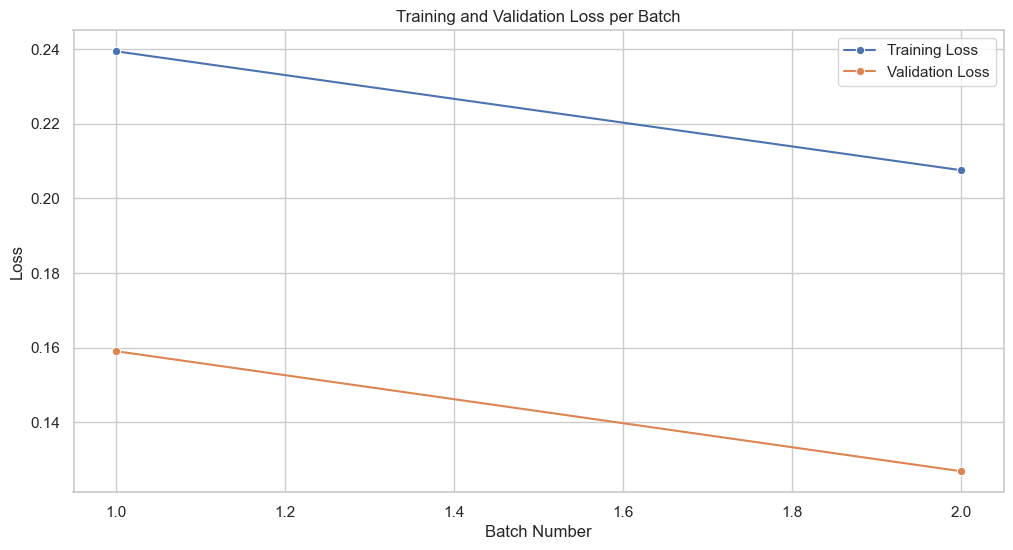

In [54]:
batch_indices = list(range(1, len(training_losses) + 1))

df = pd.DataFrame({
    "Batch": batch_indices,
    "Training Loss": training_losses,
    "Validation Loss": validation_losses
})
sns.set(style="whitegrid")

# Create a new figure
plt.figure(figsize=(12, 6))

# Plot training and validation losses
sns.lineplot(data=df, x="Batch", y="Training Loss", label="Training Loss", marker='o')
sns.lineplot(data=df, x="Batch", y="Validation Loss", label="Validation Loss", marker='o')

# Add labels and title
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')

# Show the plot
plt.legend()
plt.show()

In [55]:
batch_indices = list(range(1, len(training_losses) + 1))

df = pd.DataFrame({
    "Batch": batch_indices,
    "Training Loss": training_losses,
    "Validation Loss": validation_losses
})

In [56]:
time_id

tensor([27060, 27061, 27062, 27063, 27064, 27065, 27066])

In [57]:
with torch.no_grad():
    all_predictions = []
    targets_list = []
    timestamps = []
    site_ids = []

    for time_ids, site_id, pv_features, hrv_features, pv_targets in validation_dataloader:
        pv_features, hrv_features, pv_targets = \
            pv_features.to(device, dtype=torch.float), \
            hrv_features.to(device, dtype=torch.float), \
            pv_targets.to(device, dtype=torch.float)

        predictions = model(pv_features, hrv_features)

        # Flatten the tensors to match each prediction with a single site and timestamp
        all_predictions.extend(predictions.cpu().numpy().flatten())
        targets_list.extend(pv_targets.cpu().numpy().flatten())
        timestamps.extend([time_ids] * pv_targets.numel())
        site_ids.extend([site_id] * pv_targets.numel())

In [58]:
results_df = pd.DataFrame({
    'Predictions': all_predictions,
    'ActualTargets': targets_list
})

In [59]:
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, pin_memory=True)

In [60]:
with torch.no_grad():
    all_predictions = []
    targets_list = []
    timestamps = []
    site_ids = []

    for time_ids, site_id, pv_features, hrv_features, pv_targets in validation_dataloader:
        pv_features, hrv_features, pv_targets = \
            pv_features.to(device, dtype=torch.float), \
            hrv_features.to(device, dtype=torch.float), \
            pv_targets.to(device, dtype=torch.float)

        predictions = model(pv_features, hrv_features)
        predictions = predictions.cpu().numpy()
        targets = pv_targets.cpu().numpy()

        # Assume time_ids and site_id are lists or tensors of the same length as predictions
        if isinstance(time_ids, (list, torch.Tensor)):
            time_ids = list(time_ids)  # Convert to list if it's a tensor
        if isinstance(site_id, (list, torch.Tensor)):
            site_id = list(site_id)  # Convert to list if it's a tensor

        for i in range(len(predictions)):
            all_predictions.append(predictions[i])
            targets_list.append(targets[i])
            timestamps.append(time_ids[i].strftime('%Y-%m-%d %H:%M:%S') if isinstance(time_ids[i], datetime) else time_ids[i])
            site_ids.append(site_id[i].item() if isinstance(site_id[i], torch.Tensor) else site_id[i])

results_df = pd.DataFrame({
    'Site': site_ids,
    'Timestamp': timestamps,
    'Prediction': all_predictions,
    'Actual': targets_list
})

expanded_rows = []

# Iterate over each row in the existing DataFrame
for index, row in results_df.iterrows():
    site = row['Site']
    for timestamp, prediction, actual in zip(row['Timestamp'], row['Prediction'], row['Actual']):
        # Append a new row for each timestamp, prediction, actual value
        expanded_rows.append({
            'Site': site,
            'Timestamp': timestamp,
            'Prediction': prediction,
            'Actual': actual
        })

# Create a new DataFrame from the expanded rows
expanded_results_df = pd.DataFrame(expanded_rows)

In [61]:

expanded_results_df.to_csv("prediction_actual.csv")

In [62]:
expanded_results_df.set_index(["Site", "Timestamp"])

Prediction    Actual
Site  Timestamp                                
2626  2020-07-03T09:00:00    0.092439  0.062881
      2020-07-03T09:00:00    0.056383  0.074347
      2020-07-03T09:00:00    0.081435  0.079069
      2020-07-03T09:00:00    0.075299  0.079663
      2020-07-03T09:00:00    0.056349  0.071881
...                               ...       ...
27066 2020-07-03T19:00:00    0.022837  0.027966
      2020-07-03T19:00:00    0.023392  0.026458
      2020-07-03T19:00:00    0.002722  0.023424
      2020-07-03T19:00:00    0.022345  0.013003
      2020-07-03T19:00:00    0.029065  0.009604

[241265 rows x 2 columns]

Four hour time horizon 6x6


In [25]:
EPOCHS = 10
batch_losses = []
val_losses = []
epoch_train_losses = []
epoch_val_losses = []
for epoch in range(EPOCHS):
    model.train()

    running_loss = 0.0##sets the starting loss at zero
    count = 0#is used to keep track of the number of batches passed through the training model
  
    for i, (pv_features, hrv_features, pv_targets) in enumerate(dataloader): 
        
        optimiser.zero_grad()#resets the gradient of all the previous weights and biases used in the model, can be changed to alter the type of optimiser we use
        predictions = model(
            pv_features.to(device, dtype=torch.float),
            hrv_features.to(device, dtype=torch.float),
        )#makes predictions based off of current batch of hrv and pv inputs
        loss = criterion(predictions, pv_targets.to(device, dtype=torch.float))#calculates the loss between the models predictions and the actual pv
        loss.backward()#backprops the loss

        optimiser.step()#updates the parameters based on the calculated loss
        ###for generating the training and test loss graph
        running_loss += loss.item() * pv_targets.size(0)
        count += pv_targets.size(0)
        optimiser.step()
        
        size = int(pv_targets.size(0))#calculates the size of the first dimension of the pv_targets tensor  to determine how many data points are in the current tensor
        running_loss += float(loss) * size
        count += size
        #print(count)
        #prints the current training loss for the first 200 data points of 32 batches, then prints again once the next 200 have been computed
        if i % 200 == 199:
            print(f"Epoch {epoch + 1}, {i + 1}: {running_loss / count}")
    epoch_train_loss = running_loss / count
    epoch_train_losses.append(epoch_train_loss)        
    print(f"Epoch {epoch + 1}: {running_loss / count}")
    
    

Epoch 1, 200: 0.36770922265946865
Epoch 1, 400: 0.2938720406591892
Epoch 1, 600: 0.2535955745726824
Epoch 1, 800: 0.2209237673971802
Epoch 1, 1000: 0.2061016338393092
Epoch 1, 1200: 0.20297124555955331
Epoch 1, 1400: 0.20268771537180458
Epoch 1, 1600: 0.19519254204817116
Epoch 1, 1800: 0.18668482009321452
Epoch 1, 2000: 0.1798354455381632
Epoch 1, 2200: 0.17636673260818828
Epoch 1, 2400: 0.17655279666806262
Epoch 1, 2600: 0.17645797354670673
Epoch 1, 2800: 0.1762564202211797
Epoch 1, 3000: 0.1739811169169843
Epoch 1, 3200: 0.17064655700756703
Epoch 1, 3400: 0.1666287268632475
Epoch 1, 3600: 0.16343212737494872
Epoch 1, 3800: 0.1624090238935069
Epoch 1, 4000: 0.16172131700254977
Epoch 1, 4200: 0.16208061397341744
Epoch 1, 4400: 0.16253961996598676
Epoch 1, 4600: 0.16282881255221107
Epoch 1, 4800: 0.16330656321098408
Epoch 1, 5000: 0.16288286428153514
Epoch 1, 5200: 0.16133255959918294
Epoch 1, 5400: 0.16050589363884044
Epoch 1, 5600: 0.1600893903902865
Epoch 1, 5800: 0.15906826489669237

KeyboardInterrupt: 

Epoch 1, 4800: 0.16330656321098408 for the 6 x 6 40 layers
Epoch 2, 2200: 0.13652407970533453 for the 6 x 6 40 layers
Epoch 2: 0.14546635375772707 for the 6 x 6 40 layers



6 x 6 4 hours Epoch 1: 0.14474508166945757


In [61]:
torch.save(model.state_dict(), "submission/model.pt")

Saved version for MAE criterion 